# Oxford Pet 데이터셋 가지고 Localization, Classification 하기
+ 본과정에서는 옥스퍼드 펫 데이터셋을 가지고 Localization (객체분류+BBox)수행합니다.
+ 1개의 이미지 입력을 받아 x,y,w,h 위치 좌표와 class 정보 출력하는 모델링을 만들어 보겠습니다.
+ 모델 생성시  2개 출력 (위치 정보와 class 정보)를 Concatenate로 1개로 묶게 되며
+ 커스텀 loss function 만들어 위치 정보와 class 정보에 대해 각각 loss를 계산해고 합치게 됩니다.
+ 상세한 내용은 아래에서 실습을 같이 해 보면서 설명하도록 하겠습니다.

### 학습목차
1. Import modules
2. 데이터 준비하기
3. DataFrame에 이미지패스, class정보, 위치정보(x,y,w,h) 담자
4. 실제 이미지의 Bbox 그려보자(Localization)
5. CNN 모델로 Localization, Classification 학습하기
6. Pretrained MobileNetV2 사용하여 Localization, Classification 학습하기

# 1. import modules

In [ ]:
## library import
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
from PIL import Image
from glob import glob
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 2. 데이터 준비하기

In [ ]:
## oxford_pet.zip이 보이는지 확인
glob('oxford_pet.zip')

['oxford_pet.zip']

In [ ]:
## 압축풀기
if not os.path.exists('./oxford_pet'):
  !unzip -q oxford_pet.zip -d oxford_pet

In [ ]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [ ]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')  # BBOX 정보
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')  # Segmentation 정보

In [ ]:
print('data_dir:' ,data_dir)
print('image_dir:' ,image_dir)
print('bbox_dir:', bbox_dir)
print('seg_dir:', seg_dir)

data_dir: /content/oxford_pet
image_dir: /content/oxford_pet/images
bbox_dir: /content/oxford_pet/annotations/xmls
seg_dir: /content/oxford_pet/annotations/trimaps


In [ ]:
## image file 수 확인
image_files = [fname for fname in glob(image_dir +  '/*.jpg') if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

1200


In [ ]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
## 위의 이미지 갯수보다 annotation XML 파일 갯수가 적다. annotation XML 파일을 기준으로 해야함.

bbox_files = [fname for fname in glob(bbox_dir +  '/*.xml') if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

600

In [ ]:
## 600 bbox와 매칭되는 이미지를 모우기 위한 새로운 폴더(new_images) 생성

new_image_dir = os.path.join(data_dir, 'new_images')
os.makedirs(new_image_dir, exist_ok=True)

print('new_images:', new_image_dir)

new_images: /content/oxford_pet/new_images


In [ ]:
## 600 bbox 리스트 읽어 bbox 이름과 같은 이미지를 new_images 폴더에 복사한다.

for bbox_filename in bbox_files:
  bbox_filename = bbox_filename.split('/')[-1]
  image_name = os.path.splitext(bbox_filename)[0]
  image_file = image_dir + '/' + image_name + '.jpg'
  # print(glob(image_file))
  shutil.copy(image_file, new_image_dir)

In [ ]:
## new_images 폴더에 복사된 이미지 건수를 카운트한다.

new_image_files = glob(new_image_dir + '/*')
len(new_image_files)

600

In [ ]:
## 600개의 새로 복사된 이미지 리스트

new_image_files[:10]

['/content/oxford_pet/new_images/basset_hound_167.jpg',
 '/content/oxford_pet/new_images/beagle_125.jpg',
 '/content/oxford_pet/new_images/american_bulldog_112.jpg',
 '/content/oxford_pet/new_images/american_bulldog_14.jpg',
 '/content/oxford_pet/new_images/american_pit_bull_terrier_165.jpg',
 '/content/oxford_pet/new_images/basset_hound_158.jpg',
 '/content/oxford_pet/new_images/basset_hound_136.jpg',
 '/content/oxford_pet/new_images/boxer_151.jpg',
 '/content/oxford_pet/new_images/american_pit_bull_terrier_13.jpg',
 '/content/oxford_pet/new_images/chihuahua_100.jpg']

# 3. DataFrame에 이미지패스, class정보, 위치정보(x,y,w,h) 담자

In [ ]:
## DataFrame 만들기

pets_df = pd.DataFrame(new_image_files)
pets_df

,0
0,/content/oxford_pet/new_images/basset_hound_16...
1,/content/oxford_pet/new_images/beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...
3,/content/oxford_pet/new_images/american_bulldo...
4,/content/oxford_pet/new_images/american_pit_bu...
...,...
595,/content/oxford_pet/new_images/basset_hound_10...
596,/content/oxford_pet/new_images/basset_hound_11...
597,/content/oxford_pet/new_images/basset_hound_13...
598,/content/oxford_pet/new_images/basset_hound_11...


In [ ]:
## 컬럼명 입력

pets_df.columns = ['full_path']
pets_df.head(3)

,full_path
0,/content/oxford_pet/new_images/basset_hound_16...
1,/content/oxford_pet/new_images/beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...


In [ ]:
## full_path 컬럼에서 이미지 이름을 분리하여 file_name 컬럼명에 저장

pets_df['file_name'] = pets_df['full_path'].str.split('/').str[-1]
pets_df.head(3)

,full_path,file_name
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg


In [ ]:
## file_name 컬럼에서 라벨 분리하여 label 컬럼에 저장

pets_df['label'] = pets_df['file_name'].str.replace('_\d+','').str.split('.').str[0]

<ipython-input-19-0d2a11e4a4ec>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pets_df['label'] = pets_df['file_name'].str.replace('_\d+','').str.split('.').str[0]


In [ ]:
pets_df.head(10)

,full_path,file_name,label
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier
5,/content/oxford_pet/new_images/basset_hound_15...,basset_hound_158.jpg,basset_hound
6,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_136.jpg,basset_hound
7,/content/oxford_pet/new_images/boxer_151.jpg,boxer_151.jpg,boxer
8,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_13.jpg,american_pit_bull_terrier
9,/content/oxford_pet/new_images/chihuahua_100.jpg,chihuahua_100.jpg,chihuahua


In [ ]:
## 이미지 파일명을 입력으로 받아, 같은 이름과 xml 확장자로, 그리고 xml 위치로 변경해서 리턴

def name_convert(col):
  bbox_fname = bbox_dir + '/' + col.replace('jpg','xml')
  return bbox_fname

In [ ]:
## name_convert 함수 호출해서 이미지 파일명과 같은 이름의 xml 확장자로 만든다.

pets_df['bbox_full_path'] = pets_df['file_name'].apply(name_convert)
pets_df.head(3)

,full_path,file_name,label,bbox_full_path
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...


In [ ]:
## pets_df 데이터 구조 파악

pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_path       600 non-null    object
 1   file_name       600 non-null    object
 2   label           600 non-null    object
 3   bbox_full_path  600 non-null    object
dtypes: object(4)
memory usage: 18.9+ KB


In [ ]:
## label 분포 확인
## 각 class마다 200개 이미지 구성

pets_df['label'].value_counts()

basset_hound                 100
beagle                       100
american_bulldog             100
american_pit_bull_terrier    100
boxer                        100
chihuahua                    100
Name: label, dtype: int64

In [ ]:
## bbox_full_path 컬럼의 첫번째 데이터 가져오고 해당 내용 보기

sample_xml_file = pets_df.loc[0, 'bbox_full_path']
print(sample_xml_file)

!cat /content/oxford_pet/annotations/xmls/boxer_190.xml

/content/oxford_pet/annotations/xmls/basset_hound_167.xml
<annotation><folder>OXIIIT</folder><filename>boxer_190.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>500</width><height>333</height><depth>3</depth></size><segmented>0</segmented><object><name>dog</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>93</xmin><ymin>16</ymin><xmax>409</xmax><ymax>327</ymax></bndbox><difficult>0</difficult></object></annotation>


In [ ]:
## 1. xml Annotation 파일 읽어 이지미 크기와 Bounding box 위치을 파악
## 2. xmin, ymin, xmax, ymax 형태를  x, y(중앙), w, h 형태로 변환하여 저장

def xml_annot_getxywh(xmlfile):
  tree = et.parse(xmlfile)

  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  return x, y, w, h

In [ ]:
## 샘플 xml 파일에 대한 x, y, w, h 얻어오기

xml_annot_getxywh(sample_xml_file)

(0.504, 0.4894894894894895, 0.452, 0.5585585585585585)

In [ ]:
pets_df

,full_path,file_name,label,bbox_full_path
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...
...,...,...,...,...
595,/content/oxford_pet/new_images/basset_hound_10...,basset_hound_108.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
596,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_11.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
597,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_135.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
598,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_114.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...


In [ ]:
## xml Annot 파일의 x, y, w, h 위치 정보를 가져와 DataFrame에 저장한다.

pets_df['xywh'] = pets_df['bbox_full_path'].apply(xml_annot_getxywh)
pets_df.head()

,full_path,file_name,label,bbox_full_path,xywh
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558..."
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033..."
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,..."
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.461, 0.4853723404255319, 0.554, 0.853723404..."
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...,"(0.6366666666666667, 0.3977777777777778, 0.506..."


In [ ]:
## 튜플로 저장된 xywh 컬럼 값들을 하나씩 x, y, w, h 컬럼에 저장한다.

pets_df['x'] = pets_df['xywh'].str[0]
pets_df['y'] = pets_df['xywh'].str[1]
pets_df['w'] = pets_df['xywh'].str[2]
pets_df['h'] = pets_df['xywh'].str[3]

In [ ]:
pets_df

,full_path,file_name,label,bbox_full_path,xywh,x,y,w,h
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558...",0.504000,0.489489,0.452000,0.558559
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033...",0.411000,0.527027,0.202000,0.303303
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,...",0.421922,0.270000,0.459459,0.284000
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.461, 0.4853723404255319, 0.554, 0.853723404...",0.461000,0.485372,0.554000,0.853723
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...,"(0.6366666666666667, 0.3977777777777778, 0.506...",0.636667,0.397778,0.506667,0.715556
...,...,...,...,...,...,...,...,...,...
595,/content/oxford_pet/new_images/basset_hound_10...,basset_hound_108.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.6763157894736842, 0.375, 0.5263157894736842...",0.676316,0.375000,0.526316,0.630000
596,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_11.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.4706666666666667, 0.312, 0.5306666666666666...",0.470667,0.312000,0.530667,0.452000
597,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_135.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.777, 0.6204013377926422, 0.354, 0.571906354...",0.777000,0.620401,0.354000,0.571906
598,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_114.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.615, 0.5737951807228916, 0.326, 0.533132530...",0.615000,0.573795,0.326000,0.533133


In [ ]:
## label에 대한 라벨인코딩 수행
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
pets_df['label_conv'] = le.fit_transform(pets_df['label'])
le.classes_

array(['american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
       'beagle', 'boxer', 'chihuahua'], dtype=object)

In [ ]:
pets_df.head(3)

,full_path,file_name,label,bbox_full_path,xywh,x,y,w,h,label_conv
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558...",0.504000,0.489489,0.452000,0.558559,2
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033...",0.411000,0.527027,0.202000,0.303303,3
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,...",0.421922,0.270000,0.459459,0.284000,0


In [ ]:
## class와 idx 간의 변환

class2idx = { label : idx for idx, label in enumerate(le.classes_) }
idx2class = { idx :label for idx, label in enumerate(le.classes_) }

In [ ]:
print(class2idx)
print(idx2class)

{'american_bulldog': 0, 'american_pit_bull_terrier': 1, 'basset_hound': 2, 'beagle': 3, 'boxer': 4, 'chihuahua': 5}
{0: 'american_bulldog', 1: 'american_pit_bull_terrier', 2: 'basset_hound', 3: 'beagle', 4: 'boxer', 5: 'chihuahua'}


In [ ]:
## 이미지 패스 리스트 만들기

images_list = pets_df['full_path'].values

In [ ]:
## 이미지 파일 리스트에서 이미지 패스로 해당 이미지 읽고 리스트에 넣는다.
## 이미지 resize로 맞추지 않으면 뒤쪽에서 Tensor에러 발생한다.

x_image_list = []

for fname in images_list:
  image = Image.open(fname)
  image = image.resize((224,224))
  image = np.array(image)

  x_image_list.append(image)

x_image_list = np.array(x_image_list)

In [ ]:
## 전체 이미지 리스트 형태 보기

x_image_list.shape, type(x_image_list)

((600, 224, 224, 3), numpy.ndarray)

In [ ]:
## 이미지 라벨값과 bbox 위치값을 같이 저장한다.

y1_label = pets_df[['x', 'y', 'w', 'h', 'label_conv']].values

In [ ]:
y1_label[:4]

array([[0.504     , 0.48948949, 0.452     , 0.55855856, 2.        ],
       [0.411     , 0.52702703, 0.202     , 0.3033033 , 3.        ],
       [0.42192192, 0.27      , 0.45945946, 0.284     , 0.        ],
       [0.461     , 0.48537234, 0.554     , 0.8537234 , 0.        ]])

In [ ]:
IMG_SIZE = 224
N_BBOX = len(x_image_list)
N_TRAIN = 500
N_VAL = N_BBOX - N_TRAIN

In [ ]:
## Annotation XML 파일 갯수로 리스트 만들고 Shuffle하고 500개 Train set과 100개 Valid set으로 나눈다.

shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [ ]:
## Train set idx 보기
train_idx_list[:10]

[29, 143, 261, 569, 372, 597, 27, 424, 301, 249]

In [ ]:
## train 데이터셋 만들기

train_image_list = x_image_list[train_idx_list]
train_label = y1_label[train_idx_list]

In [ ]:
train_image_list.shape, train_label.shape

((500, 224, 224, 3), (500, 5))

In [ ]:
## valid 데이터셋 만들기

valid_image_list = x_image_list[val_idx_list]
valid_label = y1_label[val_idx_list]

In [ ]:
valid_image_list.shape, valid_label.shape

((100, 224, 224, 3), (100, 5))

In [ ]:
## Train / Valid Dataset 만들기

train_dataset_image = tf.data.Dataset.from_tensor_slices((train_image_list, train_label))
train_dataset = train_dataset_image.batch(16).shuffle(1000).repeat()

valid_dataset_image = tf.data.Dataset.from_tensor_slices((valid_image_list, valid_label))
valid_dataset = valid_dataset_image.batch(16).repeat()

# 4. 실제 이미지의 Bbox 그려보자(Localization)

In [ ]:
## Hyper Parameters

N_CLASS = len(class2idx)
N_EPOCHS = 40
N_BATCH = 16
IMG_SIZE = 224
learning_rate = 0.0001

steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## valid_dataset에서 1개 가져와 분석해 보자
## 이미지와 라벨로 받고 라벨은 다시 실제 라벨과 x,y,w,h 위치 값으로 나뉜다.

for image, label in valid_dataset.take(1):
  print(image.shape)
  print(label.shape)
  print(label[:, :4].shape)
  print(label[:, -1].shape)
  break


(16, 224, 224, 3)
(16, 5)
(16, 4)
(16,)


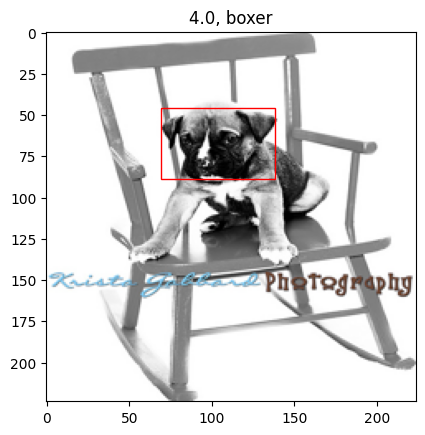

In [ ]:
## valid dataset에서 1개의 image와 bbox, label 를 읽어서 확인

cnt = 0
for image, label in valid_dataset.take(1):

    ''' matplotlib Rectangle 이용하여 사각형 그릴 경우,
    그림을 그리기 위해서 bbox의 왼쪽 아래 (xmin, ymin) 꼭지점 좌표를 계산하고,
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''

    # x, y(중앙), w, h 형태를 xmin, ymin, w, h 형태로 변환해야 함.

    x = label[:,0]
    y = label[:,1]
    w = label[:,2]
    h = label[:,3]
    classes = label[:,4].numpy()

    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)

    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.title(f'{classes[0]}, {idx2class[classes[0]]}')
    plt.imshow(image[0])
    plt.show()

# 5. CNN 모델로 Localization 학습하기

In [ ]:
# Functional API를 사용하여 모델 생성
# 입력과 출력 레이어에 이름 붙여주자!!!

def create_model():

    # 입력
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='inputs')

    # 컨볼루션
    conv = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME', name='conv2d_layer_1')(inputs)
    pool = tf.keras.layers.MaxPooling2D((2, 2), padding='SAME', name='maxpool_layer_1')(conv)

    conv = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME', name='conv2d_layer_2')(inputs)
    pool = tf.keras.layers.MaxPooling2D((2, 2), padding='SAME', name='maxpool_layer_2')(conv)

    conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME', name='conv2d_layer_3')(inputs)
    pool = tf.keras.layers.MaxPooling2D((2, 2), padding='SAME', name='maxpool_layer_3')(conv)

    conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME', name='conv2d_layer_4')(inputs)
    pool = tf.keras.layers.MaxPooling2D((2, 2), padding='SAME', name='maxpool_layer_4')(conv)
    flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

    # 출력
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
    outputs_xywh = tf.keras.layers.Dense(4, activation='sigmoid', name='get_xywh')(dense1)  # 4개 X, Y, W, H 좌표
    outputs_classes = tf.keras.layers.Dense(N_CLASS, activation='softmax', name='get_classes')(dense1)  # 6개 클래스 레이블

    concat = tf.keras.layers.Concatenate()([outputs_xywh, outputs_classes])  # 총 10개의 출력

    # 모델
    model = tf.keras.models.Model(inputs=inputs, outputs=concat)

    return model


In [ ]:
## Create model, compile & summary
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_layer_4 (Conv2D)     (None, 224, 224, 64)         1792      ['inputs[0][0]']              
                                                                                                  
 maxpool_layer_4 (MaxPoolin  (None, 112, 112, 64)         0         ['conv2d_layer_4[0][0]']      
 g2D)                                                                                             
                                                                                                  
 flatten_layer (Flatten)     (None, 802816)               0         ['maxpool_layer_4[0][0]'

In [ ]:
## 모델의 입력과 출력을 나타내는 텐서
## model.output : (None, 10) ? --> 4개의 x, y, w, h 와 class 6개 one-hot-encoding

print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


##### 모델 흐름도 그리기
![layers1](https://github.com/gzone2000/TEMP_TEST/raw/master/BB/multi_output_cnn1.png)

In [ ]:
# 커스텀 Loss Function
# 자동으로 y_true와 y_pred 두개 인자가 들어옴.
# 정답과 예측값은 10개의 값들로 구성됨 : 앞 4개(X, Y, H, W) + 뒤 6개(원핫인코딩된 Class 종류)
# 앞 4개(X, Y, H, W)와 뒤 6개(원핫인코딩된 Class 종류) 각각에 대해서 Loss 함수를 구하고 합쳐야 한다.
# cls_labels는 정답으로 숫자 1자리로 되어 있어 one-hot-encoding 되어야 함(Sparse_categorical_crossentropy 필요)
# 하지만, y_pred 경우 이미 6개 Class에 대해 one_hot_encoding 된 상태로 예측값을 주므로 인덱스 위치를 잘 찾아 비교해야함.

def loss_fn(y_true, y_pred):
  loc_labels = y_true[:,:4] # y_true[:,:4] -> 정답 bbox 4개 위치 값
  loc_preds = y_pred[:,:4] # y_pred[:,:4] -> 예측값 bbox 4개 위치 값

  cls_labels = tf.cast(y_true[:,4:], tf.int64) # y_true[:, 4:] -> 정답 class 1개 값이어서 원핫인코딩 필요
  cls_preds = y_pred[:,4:] # y_pred[:,4:] -> 예측값 class 1개값에 대해 이미 6개로 one-hot-encoding 되어 있음

  loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)  # 회귀 : MSE
  cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)  # 분류 : Crossentropy

  # 2개의 loss 함쳐 리터
  return cls_loss + 5*loc_loss

In [ ]:
# 모델 컴파일

## learning rate scheduing
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(tf.keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn, metrics=['accuracy'])

In [ ]:
## callbacks : EarlyStopping, ModelCheckpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=valid_dataset,
         validation_steps=validation_steps,
         callbacks=[es, mc])


Epoch 1/40
32/31 [==============================] - ETA: -3s - loss: 15.2068 - accuracy: 0.0640
Epoch 1: val_loss improved from inf to 13.93218, saving model to best_model_13.93.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 147s 5s/step - loss: 15.2068 - accuracy: 0.0640 - val_loss: 13.9322 - val_accuracy: 0.0700
Epoch 2/40
32/31 [==============================] - ETA: -3s - loss: 15.2015 - accuracy: 0.0640
Epoch 2: val_loss did not improve from 13.93218
31/31 [==============================] - 137s 4s/step - loss: 15.2015 - accuracy: 0.0640 - val_loss: 13.9322 - val_accuracy: 0.0700
Epoch 3/40
32/31 [==============================] - ETA: -2s - loss: 15.2015 - accuracy: 0.0640
Epoch 3: val_loss did not improve from 13.93218
31/31 [==============================] - 116s 4s/step - loss: 15.2015 - accuracy: 0.0640 - val_loss: 13.9322 - val_accuracy: 0.0700
Epoch 4/40
32/31 [==============================] - ETA: -2s - loss: 15.2015 - accuracy: 0.0640
Epoch 4: val_loss did not improve from 13.93218
31/31 [==============================] - 109s 3s/step - loss: 15.2015 - accuracy: 0.0640 - val_loss: 13.9322 - val_accuracy: 0.0700
Epoch 4: early stopping


# 6. Pretrained MobileNetV2 사용하여 학습하기

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [ ]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# Functional API를 사용하여 모델 생성
# 입력과 출력 레이어에 이름 붙여주자!!!

def create_mv_model():

    # mobilenetv2
    globalavgpool = tf.keras.layers.GlobalAveragePooling2D()(mobilenetv2.output)

    # 출력
    dense1 = tf.keras.layers.Dense(128, activation='relu')(globalavgpool)
    outputs_xywh = tf.keras.layers.Dense(4, activation='sigmoid', name='get_xywh')(dense1)
    outputs_classes = tf.keras.layers.Dense(N_CLASS, activation='softmax', name='get_classes')(dense1)

    concat = tf.keras.layers.Concatenate()([outputs_xywh, outputs_classes])

    # 모델
    model = tf.keras.models.Model(inputs=mobilenetv2.input, outputs=concat)

    return model

In [ ]:
## Create model, compile & summary
model = create_mv_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# 커스텀 Loss Function
# 자동으로 y_true와 y_pred 두개 인자가 들어옴.
# 정답과 예측값은 10개의 값들로 구성됨 : 앞 4개(X, Y, H, W) + 뒤 6개(원핫인코딩된 Class 종류)
# 앞 4개(X, Y, H, W)와 뒤 6개(원핫인코딩된 Class 종류) 각각에 대해서 Loss 함수를 구하고 합쳐야 한다.
# cls_labels는 정답으로 숫자 1자리로 되어 있어 one-hot-encoding 되어야 함(Sparse_categorical_crossentropy 필요)
# 하지만, y_pred 경우 이미 6개 Class에 대해 one_hot_encoding 된 상태로 예측값을 주므로 인덱스 위치를 잘 찾아 비교해야함.

def loss_fn(y_true, y_pred):
  loc_labels = y_true[:,:4] # y_true[:,:4] -> 정답 bbox 4개 위치 값
  loc_preds = y_pred[:,:4] # y_pred[:,:4] -> 예측값 bbox 4개 위치 값

  cls_labels = tf.cast(y_true[:,4:], tf.int64) # y_true[:, 4:] -> 정답 class 1개 값이어서 원핫인코딩 필요
  cls_preds = y_pred[:,4:] # y_pred[:,4:] -> 예측값 class 1개값에 대해 이미 6개로 one-hot-encoding 되어 있음

  loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)  # 회귀 : MSE
  cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)  # 분류 : Crossentropy

  # 2개의 loss 함쳐 리터
  return cls_loss + 5*loc_loss

In [ ]:
# 모델 컴파일

## learning rate scheduing
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(tf.keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn, metrics=['accuracy'])

In [ ]:
## callbacks : EarlyStopping, ModelCheckpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=valid_dataset,
         validation_steps=validation_steps,
         callbacks=[es, mc])


Epoch 1/40
32/31 [==============================] - ETA: -2s - loss: 1.2495 - accuracy: 0.0420
Epoch 1: val_loss improved from inf to 5.45750, saving model to best_model_5.46.h5
31/31 [==============================] - 124s 3s/step - loss: 1.2495 - accuracy: 0.0420 - val_loss: 5.4575 - val_accuracy: 0.0600
Epoch 2/40
32/31 [==============================] - ETA: -2s - loss: 0.4677 - accuracy: 0.0280
Epoch 2: val_loss did not improve from 5.45750
31/31 [==============================] - 100s 3s/step - loss: 0.4677 - accuracy: 0.0280 - val_loss: 11.8700 - val_accuracy: 0.0000e+00
Epoch 3/40
32/31 [==============================] - ETA: -2s - loss: 0.6805 - accuracy: 0.0320
Epoch 3: val_loss did not improve from 5.45750
31/31 [==============================] - 97s 3s/step - loss: 0.6805 - accuracy: 0.0320 - val_loss: 7.9170 - val_accuracy: 0.0300
Epoch 4/40
32/31 [==============================] - ETA: -2s - loss: 0.4418 - accuracy: 0.0200
Epoch 4: val_loss did not improve from 5.45750
31

1/1 [==============================] - 2s 2s/step


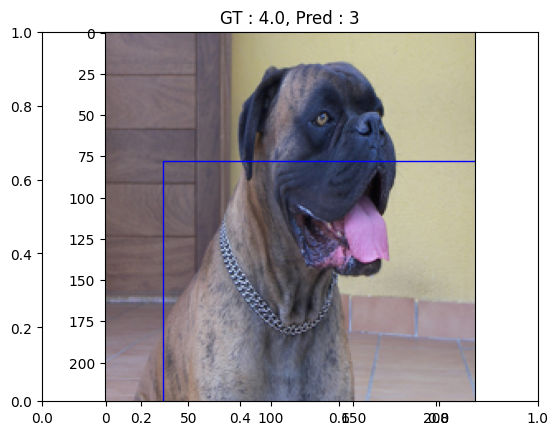

1/1 [==============================] - 1s 912ms/step


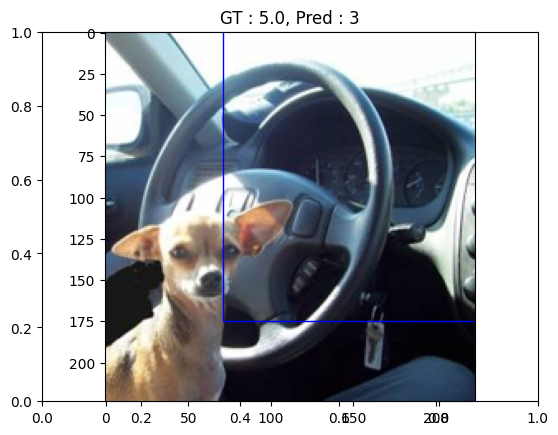

1/1 [==============================] - 1s 757ms/step


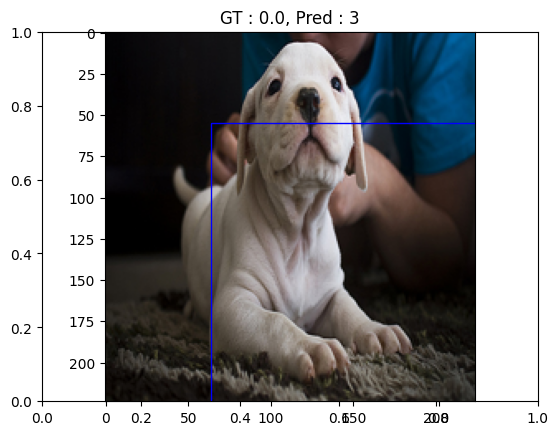

1/1 [==============================] - 1s 711ms/step


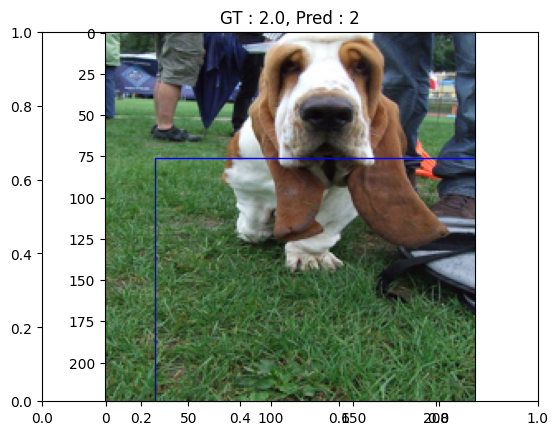

1/1 [==============================] - 0s 441ms/step


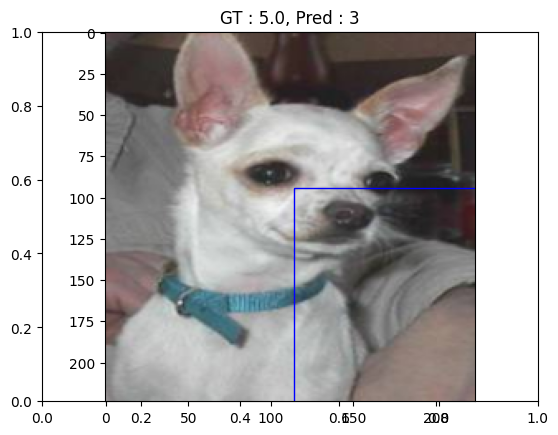

1/1 [==============================] - 0s 479ms/step


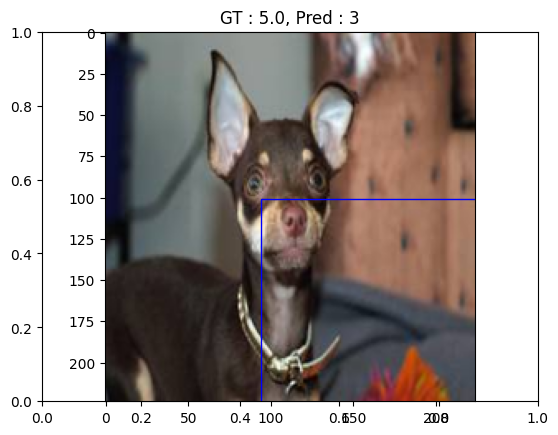

1/1 [==============================] - 0s 132ms/step


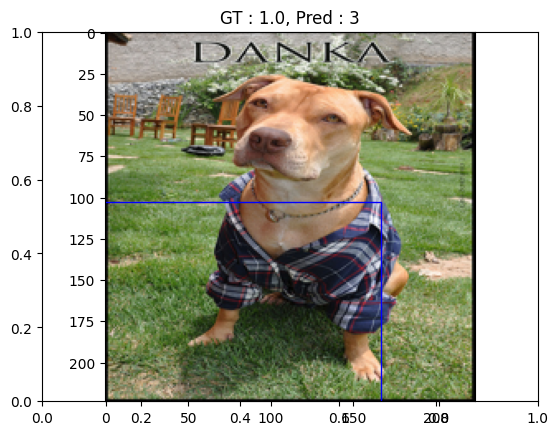

In [ ]:
# validation data 일부 읽어와 예측해 보고 Class와 Bbox에 대한 정답과 예측 확인
## 정답은 빨간색 box, 예측은 파란색 box

idx = 2
num_imgs = validation_steps

# val_dataset 포맷: (None, 224, 224, 3), (None, 5)
for val_data, val_gt in valid_dataset.take(num_imgs):

    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    gt_class = val_gt[:,4]

    gt_class_num = gt_class[idx]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)

    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data) # prediction.shape : (None, 10)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_class = np.argmax(prediction[:,4:], axis=1)

    pred_class_num = pred_class[idx]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)

    ## image와 bbox 함께 출력
    plt.title(f'GT : {gt_class_num}, Pred : {pred_class_num}')
    plt.imshow(val_data[idx])
    plt.show()

## 배운 내용 정리
1. Oxford Pet 데이터셋 가지고 Localization(객체분류+Bbox) 실습해 보았습니다.
2. 실제 이미지의 Bbox 그려보자(Localization)
3. CNN 모델로 Localization, Classification 학습해 보았으며
4. Pretrained MobileNetV2 사용하여 Localization, Classification 모델을 만들어 학습해 보았습니다.
5. 객체탐지가 생각보다 성능이 잘 나오지 않고 있음을 알수 있었습니다.
6. 우리는 이미 학습되고 성능 잘 나오는 Yolo, SSD 등의 객체탐지 모델을 가져와 Fine Tuning해서 사용하면 되겠습니다.